In [1]:
import pylab
import pymoc
import numpy as np
%matplotlib inline
import pylab as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import Column
from astropy import wcs

import xidplus

This notebook uses all the raw data from the masterlist, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. Here we use the DataFusion-Spitzer MOC.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_HDF-N/data/holes_HDF-N_irac1_O16_20190201_WARNING-MADE-WITH-Lockman-SWIRE-PARAMS.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../../dmu17/dmu17_HELP_SEIP_maps/HDF-N/data/70101860.70101860-0.MIPS.1.moc.fits')

In [3]:
Final=Sel_func.intersection(SWIRE_MOC)

In [41]:
Final.write('./data/testMoc.fits', overwrite=True)

## Read in Masterlist
Next step is to read in Masterlist and select only sources that are detected in mid-infrared and at least one other wavelength domain (i.e. optical or nir). This will remove most of the objects in the catalogue that are artefacts. We can do this by using the `flag_optnir_det` flag and selecting sources that have a binary value of $>= 5$

In [4]:
from astropy.io import fits
# masterfile='master_catalogue_hdf-n_20180427.fits'
masterfile='master_catalogue_hdf-n_20201103.fits'

masterlist=fits.open('../../dmu1/dmu1_ml_HDF-N/data/'+masterfile)

In [5]:
len(masterlist[1].data)

130679

In [6]:
# good=masterlist[1].data['flag_optnir_det']>=5

# good.sum()

In [7]:
ind=masterlist[1].data['flag_optnir_det']>=5
good = ((masterlist[1].data[ind]['f_irac_i1']>=5) |( masterlist[1].data[ind]['f_irac_i2']>=5)| 
        (masterlist[1].data[ind]['f_irac_i3']>=5 )| (masterlist[1].data[ind]['f_irac_i4']>=5))

good.sum()

3712

### Create uninformative (i.e. conservative) upper and lower limits based on IRAC fluxes
As the default flux prior for XID+ is a uniform distribution, it makes sense to set reasonable upper and lower 24 micron flux limits based on the longest wavelength IRAC flux available. For a lower limit I take IRAC/500.0 and for upper limit I take IRACx500.

In [8]:
MIPS_lower=np.full(good.sum(),0.0)
MIPS_upper=np.full(good.sum(),1E5)

In [9]:
len(MIPS_lower)

3712

In [10]:
masterlist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1423 / length of dimension 1                          
NAXIS2  =               130679 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  199 / number of table fields                         
TTYPE1  = 'ra      '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'deg     '                                                            
TTYPE2  = 'dec     '                                                            
TFORM2  = 'D       '        

In [11]:
#for i in range(0,good.sum()):
#    if masterlist[1].data['flag_irac_i4'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac_i4'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac_i4'][good][i]*500.0
#    elif masterlist[1].data['flag_irac_i3'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac_i3'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac_i3'][good][i]*500.0
#    elif masterlist[1].data['flag_irac_i2'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac_i2'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac_i2'][good][i]*500.0
#    elif masterlist[1].data['flag_irac_i1'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac_i1'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac_i1'][good][i]*500.0

In [12]:
for i in range(0,good.sum()):
    if ~np.isnan(masterlist[1].data['f_irac_i4'][ind][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i4'][ind][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i4'][ind][good][i]*500.0
    elif ~np.isnan(masterlist[1].data['f_irac_i3'][ind][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i3'][ind][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i3'][ind][good][i]*500.0
    elif ~np.isnan(masterlist[1].data['f_irac_i2'][ind][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i2'][ind][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i2'][ind][good][i]*500.0
    elif ~np.isnan(masterlist[1].data['f_irac_i1'][ind][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i1'][ind][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i1'][ind][good][i]*500.0
        

In [44]:
np.savez('././data/tmp_mips_prior_iraccut5', MIPS_lower, MIPS_upper)

In [11]:
# npzfile = np.load('./data/tmp_mips_prior.npz')
# MIPS_lower=npzfile['arr_0']
# MIPS_upper=npzfile['arr_1']

In [13]:
np.sum(masterlist[1].data['f_irac_i1'][ind][good]>0)

3659

In [14]:
MIPS_upper

array([ 1080.355,  -100.325,  -123.56 , ..., 10265.32 ,  2013.   ,
         -66.18 ])

## Read in Map
We are now ready to read in the MIPS map


In [14]:
mapfile =  '70101860.70101860-0.MIPS.1.help.fits' #'70101860.70101860-0.MIPS.2.mosaic.fits' 
# errmap ='70101860.70101860-0.MIPS.2.std.fits'

In [16]:
MIPS_Map=fits.open('../../dmu17/dmu17_HELP_SEIP_maps/HDF-N/data/'+ mapfile)
# MIPS_errMap=fits.open('../../dmu17/dmu17_SEIP_maps/HDF-N/data/'+ errmap)

In [19]:
w_im = wcs.WCS(MIPS_Map[1].header) 
w_nim = wcs.WCS(MIPS_Map[2].header) 
print('w_im: ', w_im, '\n w_nim: ', w_nim)

w_im:  WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 189.510210886  62.4063703094  
CRPIX : 1009.913  1119.16  
CD1_1 CD1_2  : -0.000680556  -0.0  
CD2_1 CD2_2  : -0.0  0.000680556  
NAXIS : 2019  2237 
 w_nim:  WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 189.510377  62.40646  
CRPIX : 1009.913  1119.16  
CD1_1 CD1_2  : -0.000680556  -0.0  
CD2_1 CD2_2  : -0.0  0.000680556  
NAXIS : 2019  2237


keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]
keyword looks very much like CRVALia but isn't. [astropy.wcs.wcs]


In [22]:
MIPS_Map[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel - floating point                
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1243 / X axis length                                  
NAXIS2  =                 1371 / Y axis length                                  
ORIGIN  = 'Spitzer Super-Mosaic Pipeline' / Origin of these image data          
CREATOR = 'Spitzer Science Center' / Creator of this FITS file                  
                                                                                
          / TIME AND EXPOSURE INFORMATION                                       
                                                                                
TELESCOP= 'Spitzer '           / Name of Telescope                              
INSTRUME= 'MIPS    '           / Name of Instrument                             
CHNLNUM =                   

In [17]:
MIPS_Map[0].header['CRVAL1']

KeyError: "Keyword 'CRVAL1' not found."

In [17]:
MIPS_Map[1].header['CRVAL1']=MIPS_Map[2].header['CRVAL1']
MIPS_Map[1].header['CRVAL2']=MIPS_Map[2].header['CRVAL2']

In [18]:
#MIPS_Map.writeto('../../dmu17/dmu17_HELP-SEIP-maps/HDF-N/data/70101860.70101860-0.MIPS.1.help2.fits')

In [19]:
#MIPS_Map[1].header

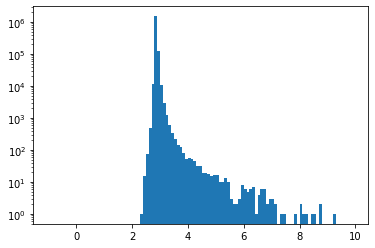

In [21]:
data=MIPS_Map[1].data
plt.hist(data.flatten(),bins=np.arange(-1.0,10.0,0.1));
plt.yscale('log')

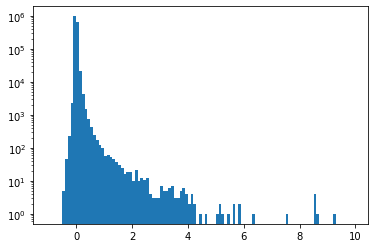

In [23]:
data=MIPS_Map[1].data
plt.hist(data.flatten()-np.nanmean(data.flatten()),bins=np.arange(-1.0,10.0,0.1));
plt.yscale('log')

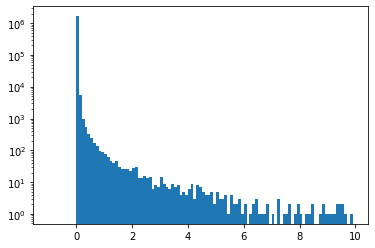

In [22]:
data_err=MIPS_Map[2].data
plt.hist(data_err.flatten(),bins=np.arange(-1.0,10.0,0.1));
plt.yscale('log')

## Read in PSF

In [24]:
MIPS_psf=fits.open('../../dmu17/dmu17_HELP_SEIP_maps/HDF-N/data/output_data/dmu17_MIPS_HDF-N_20201111.fits')#data/output_data/dmu17_MIPS_HDF-N_20190327.fits')

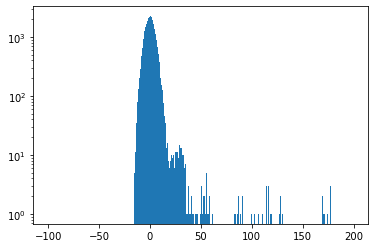

In [25]:
dat=MIPS_psf[1].data
plt.hist(dat.flatten(),bins=np.arange(-100.0,200.0,1.0));
plt.yscale('log')

In [26]:
np.mean(~np.isnan(dat))

1.0

In [27]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=11

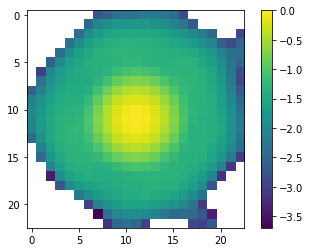

In [28]:
plt.imshow(np.log10(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/np.max(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1])))
plt.colorbar()

## Set XID+ prior class

In [39]:
len(MIPS_upper)

13500

In [34]:
prior_MIPS=xidplus.prior(MIPS_Map[1].data - np.nanmean(MIPS_Map[1].data),MIPS_Map[2].data,MIPS_Map[1].header,MIPS_Map[2].header,moc=Final)

prior_MIPS.prior_cat(masterlist[1].data['ra'][ind][good],masterlist[1].data['dec'][ind][good],masterfile,flux_lower=MIPS_lower,
                     flux_upper=MIPS_upper,ID=masterlist[1].data['help_id'][ind][good])



In [53]:
# MIPS_Map[1].data = MIPS_Map[1].data - np.nanmean(MIPS_Map[1].data)
# MIPS_Map.writeto('../../dmu17/dmu17_HELP_SEIP_maps/HDF-N/data/70101860.70101860-0.MIPS.1.help_meansubs.fits',overwrite=True)

In [35]:
prior_MIPS.sra

array([189.36631367, 189.36690145, 189.3673755 , ..., 189.41525785,
       189.12525768, 189.17867959])

([<aplpy.core.FITSFigure at 0x7f1eac175b20>],
 <Figure size 720x720 with 2 Axes>)

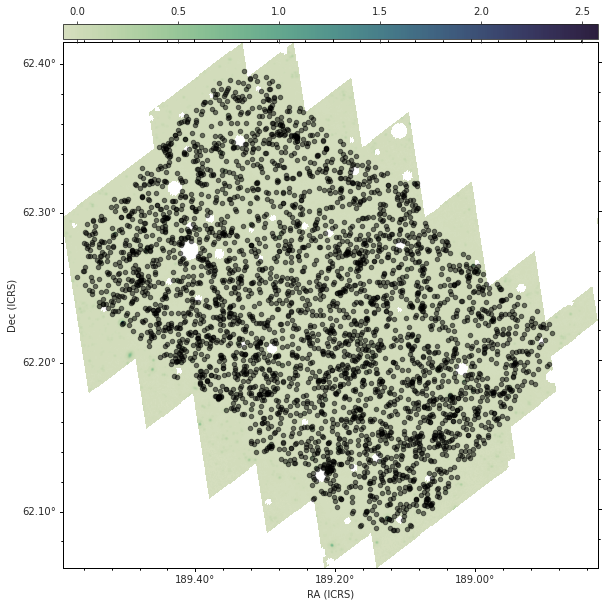

In [36]:
xidplus.plot_map([prior_MIPS])

In [37]:
prior_MIPS.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,23/2.0,0.5),np.arange(0,23/2.0,0.5))



In [38]:
MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1].shape

(23, 23)

## Calculate tiles
As fitting the whole map would be too computationally expensive, I split based on HEALPix pixels. For MIPS, the optimum order is 11. So that I don't have to read the master prior based on the whole map into memory each time (which requires a lot more memory) I also create another layer of HEALPix pixels based at the lower order of 6.

In [39]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/20210128_meansub/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior_MIPS],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 87 tiles required for input catalogue and 1 large tiles


SystemExit: 

In [40]:
prior_MIPS.nsrc

3597

In [41]:
mean_data = np.mean(data[~np.isnan(data)])


In [44]:
mean_data

2.8633354

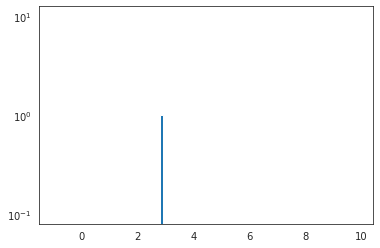

In [43]:
plt.hist(mean_data,bins=np.arange(-1.0,10.0,0.1));
plt.yscale('log')